In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Постановка задачи**



**Наша задача** — обучить две нейронные сети для использования в робототехническом алгоритме манипулирования: "Планирование манипулирования объектом с помощью дерева Монте-Карло".

**Оригинальная статья алгоритма**:
https://arxiv.org/abs/2206.09023

**Решаемая задача алгоритмом**: планирование манипулирования объектом, у которого присутствуют грани в виде выпуклых многогранников, по зараннее заданной траектории. В каждый момент времени для объекта заданы векторы:

$q(t)=[p(t),R(t)], dq(t)/dt=[v(t), w(t)], d^2q(t)/dt^2=[a(t),β(t)]$,

где $p(t)$ - коордианты расположения объекта, $R(t)$ - угол поворота объекта относительного начального состояния.

Алгоритм рассчитывает куда и какие силы прилагать на объект с помощью манипулятора, чтобы в каждый момент времени кинематические характеристики объекта удовлетворяли заданным траекторией.

**Пример траектории**:



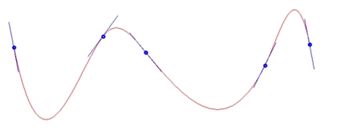

Работу алгоритма можно разделить на 2 этапа. На первом этапе происходит выбор граней к которым будут прилагаться силы в каждый момент времени, на втором этапе с помощью оптимизатора рассчитываются сами силы и точки их приложения.

**Задача нейронной сети политики:** определять ценность последовательности гранней исходя из траектории и возвращать распределение вероятностей по граням для следующего выбора.

**Задача нейронной сети классификатора:** отсекать последовательность граней, к которым нельзя приложить силы так, чтобы объект следовал по траектории.

**Схема работы алгоритма** представлена на следующем рисунке.

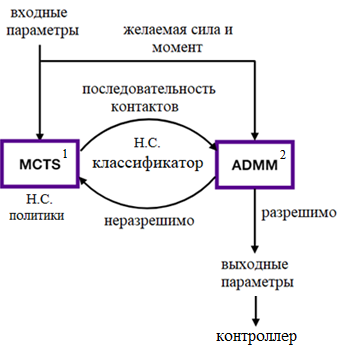


**Пример объекта манипулирования**:

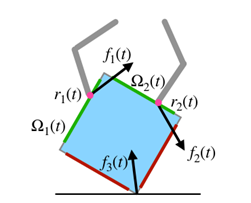


# **Описание набора данных**



Данные описывают эмпирические данные по состояним, действиям, цели и ценности. **Данные для обучения были заранее сгенерированы** в ide pycharm  в процессе моделирования функционирования алгоритма
без нейронной сети классификатора и необученной нейронной сети политики.

**Директория** кода алгоритма манипулирования для генерации данных и тестирования алгоритма манипулирования: https://github.com/machines-in-motion/contact_mcts

**Таблица. Пояснение признаков**

Признак  | Описание
-------------------|--------------------
states       | испробованная последовательность граней, которая выбирались для приложения сил
values       | ценность выбора данной последовательности граней
action_probs       | распределение вероятностей выбора новых граней для приложения сил и следования траектории
goals       | λ(t)=q(t+h)⊝q(t) - промежуточные цели, где q(t)=[p(t),R(t)] - вектор линейного и углового положения объекта.



# **Архитектура нейронных сетей**




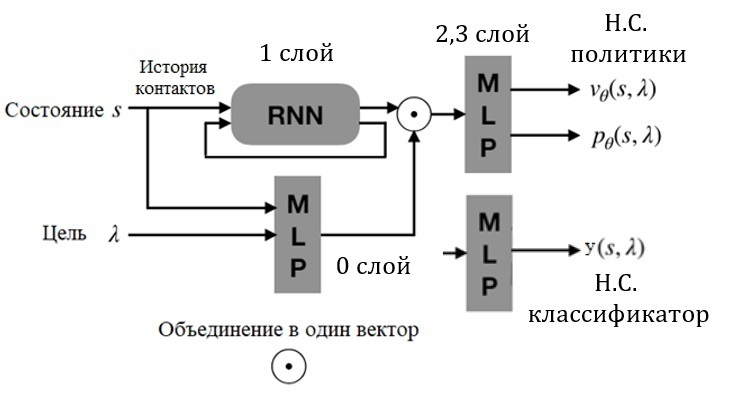

где $λ(t)=q(t+h)⊝q(t)$ - промежуточная цель

# **Классы нейронных сетей**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class PolicyValueNet(nn.Module):
    def __init__(self, input_size=2, action_size=31, goal_size=12, hidden_size=10):
        # game params
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size,nonlinearity = "relu",
                        batch_first=True)
        self.fc0 = nn.Linear(goal_size, 1024)
        self.bn0 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(hidden_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.dropout = nn.Dropout(p=0.5)

        self.policy_head = nn.Linear(512, action_size)
        self.value_head = nn.Linear(512, 1)

    def forward(self, state, goal):

        output, h = self.rnn(state)
        x = h[0]

        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        g = self.dropout(F.relu(self.bn0(self.fc0(goal))))

        x = torch.cat((x, g), 1)

        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))

        pi = F.log_softmax(self.policy_head(x), dim=1)# batch_size x action_size
        v = self.value_head(x)# batch_size x 1

        return pi, v


class ValueClassifier(nn.Module):
    def __init__(self, input_size=2, action_size=31, goal_size=12, hidden_size=10):
        # game params
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size,
                          nonlinearity='relu', batch_first=True)
        # relu
        self.fc0 = nn.Linear(goal_size, 1024)
        self.bn0 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(hidden_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.dropout = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(512, 1)


    def forward(self, state, goal):

        output, h = self.rnn(state)
        x = h[0]

        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        g = self.dropout(F.relu(self.bn0(self.fc0(goal))))

        x = torch.cat((x, g), 1)

        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))

        y = self.fc4(x)# batch_size x 1

        return y

def pad_collate(batch):
    (states, values, action_probs, goals) = zip(*batch)
    state_lens = torch.tensor([len(state) for state in states]).cpu()
    states = [torch.tensor(state) for state in states]
    values = torch.tensor(values)[:, None]
    action_probs = torch.tensor(np.array(action_probs))
    goals =  torch.tensor(np.array(goals))
    states_pad = pad_sequence(states, batch_first=True, padding_value=0)
    return states_pad, state_lens, values, action_probs, goals

# **Загрузка и подготовка данных**



In [ ]:
data_path_csv = "/content/data.csv"

In [ ]:
from torch.utils.data import Dataset

class MCTSDataset(Dataset):
    def __init__(self, states, values, action_probs, goals):
        super().__init__()
        self.states = states
        self.values = values
        self.action_probs = action_probs
        self.goals = goals

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        return self.states[idx], self.values[idx], self.action_probs[idx], self.goals[idx]


In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt



from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import re
def valid_data_format(input_string):
  # print(input_string)
  out = input_string.strip()[1:-1]
  out = out.split()
  # Convert each value to a float and create a list
  result = [float(x) for x in out]
  # print(result)
  return result


In [ ]:
states = []
values = []
action_probs = []
goals = []
import csv
import ast
with open(data_path_csv, newline='') as csvfile:
    data = csv.DictReader(csvfile)
    for row in data:
      s = ast.literal_eval(row['states'])
      v = np.float64(ast.literal_eval(row['values']))
      p = valid_data_format(row['action_probs'])
      g = valid_data_format(row['goals'])
      g = np.array(g)
      p = np.array(p)

      states.append(s)
      action_probs.append(p)
      goals.append(g)

      if v > 0:
          values.append(1)
      else:
          values.append(0)

data_classifier = MCTSDataset(states, values, action_probs, goals)




In [ ]:
states = []
values = []
action_probs = []
goals = []

with open(data_path_csv,newline='') as csvfile:
  data = csv.DictReader(csvfile)
  for row in data:
    v = np.float64(ast.literal_eval(row['values']))
    if v > 0:
      s = ast.literal_eval(row['states'])
      p = valid_data_format(row['action_probs'])
      g = valid_data_format(row['goals'])

      g = np.array(g)
      p = np.array(p)

      states.append(s)
      values.append(v)
      action_probs.append(p)
      goals.append(g)

data_pvnet = MCTSDataset(states, values, action_probs, goals)



In [ ]:
n_train_classifier = int(0.9*len(data_classifier))
n_test_classifier = len(data_classifier) - n_train_classifier
train_data_classifier, test_data_classifier = torch.utils.data.random_split(data_classifier,
                                                                            [n_train_classifier,
                                                                             n_test_classifier])

n_train_pvnet = int(0.9*len(data_pvnet))
n_test_pvnet = len(data_pvnet) - n_train_pvnet
train_data_pvnet, test_data_pvnet = torch.utils.data.random_split(data_pvnet,
                                                                  [n_train_pvnet,
                                                                   n_test_pvnet])



In [ ]:

train_loader_classifier = DataLoader(train_data_classifier, batch_size=128,
                                      shuffle=True, collate_fn=pad_collate)
train_loader_pvnet = DataLoader(train_data_pvnet, batch_size=128,
                              shuffle=True, collate_fn=pad_collate)



# **Обучение**

***Функции потерь:***

Во время обучения на созданных данных обновление параметров нейронной сети классификатора происходит на основе функции потерии бинарной кросс-энтропии использующей сигму функцию:

$L=L\{l_1​,…,l_N​\}^⊤$

$l_n​=−w\cdot n​[y_n​⋅log(σ(x_n​))+(1−y_n​)⋅log(1−σ(x_n​))]$

$L = mean(l_n)$,


 Обновление нейронной сети политики происходит на основе среднеквадратичной ошибки $l_v$ для значений ценности состояния и на основе функции потерь кросс-энтропии $l_p$ для значений, которые определяют выбор граней:

$l_{v} (s)=(v_θ (s)-v ̅(s))^2$

$l_{p} (s)=-∑_{(a∈A(s))}p(s,a) log(p_{θ}(s,a))$,

где $D={(v ̅(s),p ̅(s,a))|∈V}$ - история, $s$ – это посещенное состояние,

Суммарная ошибка:

$l(D)=\frac{1}{|D|}∑_{(s∈V)}(l_{v} (s)+l_{p}(s))$,

где $D=(v ̅(s),p ̅(s,a))|∈V$, где $s$ – это посещенное состояние,

$p ̅(s,a)=N(s,a)/∑_{b}N(s,b)$ – эмпирическая вероятность пары

$v ̅(s)=∑_{(a∈A(s))}p ̅(s,a)Q(s,a)$ – ожидаемая ценность состояния


***Параметры обучения:***

Количество эпох: 300

Размер батча: 128


In [ ]:
value_classifier = ValueClassifier().to(device)
optimizer = torch.optim.Adam(value_classifier.parameters())
value_classifier.train()

class_ratio = (len(train_data_classifier) - len(train_data_pvnet)) / len(train_data_pvnet)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_ratio]).to(device))
ess = 300

tepoch = tqdm(range(ess))

for epoch in tepoch:
    running_loss = 0
    n_batches = 0
    for padded_state, state_length, v, p, g in train_loader_classifier:
        optimizer.zero_grad()
        packed_state = pack_padded_sequence(padded_state, state_length,
                                            enforce_sorted=False, batch_first=True)
        y_pred = value_classifier(packed_state.to(device).float(),
                                  g.to(device).float())
        loss = bce_loss(y_pred, v.to(device).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_batches += 1
    tepoch.set_postfix(epoch_loss=running_loss/n_batches)



100%|██████████| 300/300 [33:45<00:00,  6.75s/it, epoch_loss=0.245]


In [ ]:
pvnet = PolicyValueNet().to(device)
optimizer = torch.optim.Adam(pvnet.parameters())
pvnet.train()

tepoch = tqdm(range(ess))

for epoch in tepoch:
    running_loss = 0
    n_batches = 0
    for padded_state, state_length, v, p, g in train_loader_pvnet:
        optimizer.zero_grad()
        packed_state = pack_padded_sequence(padded_state, state_length,
                                            enforce_sorted=False, batch_first=True)
        pi_pred, v_pred = pvnet(packed_state.to(device).float(), g.to(device).float())
        value_loss = F.mse_loss(v.to(device).float(), v_pred)
        policy_loss = -torch.mean(torch.sum(p.to(device) * pi_pred, 1))
        loss = value_loss + policy_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_batches += 1
    tepoch.set_postfix(epoch_loss=running_loss/n_batches)


  0%|          | 0/300 [00:00<?, ?it/s]

0


  0%|          | 1/300 [00:04<20:05,  4.03s/it, epoch_loss=0.913]

1


  1%|          | 2/300 [00:07<19:34,  3.94s/it, epoch_loss=0.615]

2


  1%|          | 3/300 [00:12<21:24,  4.33s/it, epoch_loss=0.586]

3


  1%|▏         | 4/300 [00:16<20:22,  4.13s/it, epoch_loss=0.573]

4


  2%|▏         | 5/300 [00:20<19:53,  4.05s/it, epoch_loss=0.562]

5


  2%|▏         | 6/300 [00:25<21:03,  4.30s/it, epoch_loss=0.556]

6


  2%|▏         | 7/300 [00:29<20:17,  4.15s/it, epoch_loss=0.549]

7


  3%|▎         | 8/300 [00:32<19:44,  4.06s/it, epoch_loss=0.545]

8


  3%|▎         | 9/300 [00:37<20:48,  4.29s/it, epoch_loss=0.539]

9


  3%|▎         | 10/300 [00:41<20:01,  4.14s/it, epoch_loss=0.537]

10


  4%|▎         | 11/300 [00:45<19:31,  4.05s/it, epoch_loss=0.53]

11


  4%|▍         | 12/300 [00:49<20:13,  4.21s/it, epoch_loss=0.527]

12


  4%|▍         | 13/300 [00:54<20:24,  4.27s/it, epoch_loss=0.522]

13


  5%|▍         | 14/300 [00:58<20:50,  4.37s/it, epoch_loss=0.517]

14


  5%|▌         | 15/300 [01:03<21:19,  4.49s/it, epoch_loss=0.514]

15


  5%|▌         | 16/300 [01:07<20:27,  4.32s/it, epoch_loss=0.509]

16


  6%|▌         | 17/300 [01:11<19:42,  4.18s/it, epoch_loss=0.501]

17


  6%|▌         | 18/300 [01:15<19:55,  4.24s/it, epoch_loss=0.492]

18


  6%|▋         | 19/300 [01:20<19:55,  4.25s/it, epoch_loss=0.477]

19


  7%|▋         | 20/300 [01:24<19:16,  4.13s/it, epoch_loss=0.462]

20


  7%|▋         | 21/300 [01:28<19:14,  4.14s/it, epoch_loss=0.453]

21


  7%|▋         | 22/300 [01:32<19:37,  4.24s/it, epoch_loss=0.448]

22


  8%|▊         | 23/300 [01:36<19:03,  4.13s/it, epoch_loss=0.439]

23


  8%|▊         | 24/300 [01:40<18:33,  4.04s/it, epoch_loss=0.426]

24


  8%|▊         | 25/300 [01:45<19:32,  4.26s/it, epoch_loss=0.413]

25


  9%|▊         | 26/300 [01:49<18:57,  4.15s/it, epoch_loss=0.4]

26


  9%|▉         | 27/300 [01:52<18:28,  4.06s/it, epoch_loss=0.393]

27


  9%|▉         | 28/300 [01:57<19:27,  4.29s/it, epoch_loss=0.389]

28


 10%|▉         | 29/300 [02:01<18:50,  4.17s/it, epoch_loss=0.384]

29


 10%|█         | 30/300 [02:05<18:23,  4.09s/it, epoch_loss=0.383]

30


 10%|█         | 31/300 [02:10<19:23,  4.32s/it, epoch_loss=0.378]

31


 11%|█         | 32/300 [02:14<18:39,  4.18s/it, epoch_loss=0.379]

32


 11%|█         | 33/300 [02:18<18:09,  4.08s/it, epoch_loss=0.378]

33


 11%|█▏        | 34/300 [02:22<19:01,  4.29s/it, epoch_loss=0.376]

34


 12%|█▏        | 35/300 [02:26<18:28,  4.18s/it, epoch_loss=0.377]

35


 12%|█▏        | 36/300 [02:30<17:58,  4.08s/it, epoch_loss=0.373]

36


 12%|█▏        | 37/300 [02:35<18:23,  4.19s/it, epoch_loss=0.372]

37


 13%|█▎        | 38/300 [02:39<18:23,  4.21s/it, epoch_loss=0.372]

38


 13%|█▎        | 39/300 [02:43<17:51,  4.10s/it, epoch_loss=0.37]

39


 13%|█▎        | 40/300 [02:47<17:55,  4.14s/it, epoch_loss=0.371]

40


 14%|█▎        | 41/300 [02:51<18:24,  4.26s/it, epoch_loss=0.369]

41


 14%|█▍        | 42/300 [02:55<17:48,  4.14s/it, epoch_loss=0.37]

42


 14%|█▍        | 43/300 [03:01<19:09,  4.47s/it, epoch_loss=0.366]

43


 15%|█▍        | 44/300 [03:05<19:16,  4.52s/it, epoch_loss=0.367]

44


 15%|█▌        | 45/300 [03:09<18:25,  4.33s/it, epoch_loss=0.366]

45


 15%|█▌        | 46/300 [03:13<17:45,  4.20s/it, epoch_loss=0.366]

46


 16%|█▌        | 47/300 [03:18<18:30,  4.39s/it, epoch_loss=0.365]

47


 16%|█▌        | 48/300 [03:22<17:47,  4.23s/it, epoch_loss=0.365]

48


 16%|█▋        | 49/300 [03:26<17:15,  4.13s/it, epoch_loss=0.364]

49


 17%|█▋        | 50/300 [03:30<18:02,  4.33s/it, epoch_loss=0.364]

50


 17%|█▋        | 51/300 [03:34<17:22,  4.19s/it, epoch_loss=0.363]

51


 17%|█▋        | 52/300 [03:38<16:52,  4.08s/it, epoch_loss=0.362]

52


 18%|█▊        | 53/300 [03:43<17:44,  4.31s/it, epoch_loss=0.363]

53


 18%|█▊        | 54/300 [03:47<17:05,  4.17s/it, epoch_loss=0.362]

54


 18%|█▊        | 55/300 [03:51<16:41,  4.09s/it, epoch_loss=0.36]

55


 19%|█▊        | 56/300 [03:55<17:23,  4.28s/it, epoch_loss=0.361]

56


 19%|█▉        | 57/300 [03:59<16:54,  4.18s/it, epoch_loss=0.361]

57


 19%|█▉        | 58/300 [04:03<16:22,  4.06s/it, epoch_loss=0.359]

58


 20%|█▉        | 59/300 [04:07<16:40,  4.15s/it, epoch_loss=0.361]

59


 20%|██        | 60/300 [04:12<16:46,  4.19s/it, epoch_loss=0.358]

60


 20%|██        | 61/300 [04:16<16:19,  4.10s/it, epoch_loss=0.358]

61


 21%|██        | 62/300 [04:20<16:14,  4.09s/it, epoch_loss=0.357]

62


 21%|██        | 63/300 [04:24<16:46,  4.25s/it, epoch_loss=0.356]

63


 21%|██▏       | 64/300 [04:28<16:13,  4.12s/it, epoch_loss=0.357]

64


 22%|██▏       | 65/300 [04:32<15:50,  4.04s/it, epoch_loss=0.356]

65


 22%|██▏       | 66/300 [04:37<16:39,  4.27s/it, epoch_loss=0.357]

66


 22%|██▏       | 67/300 [04:41<16:06,  4.15s/it, epoch_loss=0.356]

67


 23%|██▎       | 68/300 [04:44<15:39,  4.05s/it, epoch_loss=0.356]

68


 23%|██▎       | 69/300 [04:49<16:32,  4.30s/it, epoch_loss=0.356]

69


 23%|██▎       | 70/300 [04:53<15:57,  4.16s/it, epoch_loss=0.355]

70


 24%|██▎       | 71/300 [04:57<15:32,  4.07s/it, epoch_loss=0.353]

71


 24%|██▍       | 72/300 [05:02<16:37,  4.38s/it, epoch_loss=0.355]

72


 24%|██▍       | 73/300 [05:07<16:54,  4.47s/it, epoch_loss=0.355]

73


 25%|██▍       | 74/300 [05:11<16:06,  4.28s/it, epoch_loss=0.353]

74


 25%|██▌       | 75/300 [05:15<16:37,  4.43s/it, epoch_loss=0.352]

75


 25%|██▌       | 76/300 [05:19<15:54,  4.26s/it, epoch_loss=0.351]

76


 26%|██▌       | 77/300 [05:23<15:22,  4.13s/it, epoch_loss=0.351]

77


 26%|██▌       | 78/300 [05:28<15:56,  4.31s/it, epoch_loss=0.355]

78


 26%|██▋       | 79/300 [05:32<15:31,  4.21s/it, epoch_loss=0.352]

79


 27%|██▋       | 80/300 [05:36<15:01,  4.10s/it, epoch_loss=0.351]

80


 27%|██▋       | 81/300 [05:40<15:13,  4.17s/it, epoch_loss=0.351]

81


 27%|██▋       | 82/300 [05:44<15:20,  4.22s/it, epoch_loss=0.35]

82


 28%|██▊       | 83/300 [05:48<14:52,  4.11s/it, epoch_loss=0.35]

83


 28%|██▊       | 84/300 [05:52<14:53,  4.14s/it, epoch_loss=0.351]

84


 28%|██▊       | 85/300 [05:57<15:17,  4.27s/it, epoch_loss=0.352]

85


 29%|██▊       | 86/300 [06:01<14:46,  4.14s/it, epoch_loss=0.349]

86


 29%|██▉       | 87/300 [06:05<14:25,  4.07s/it, epoch_loss=0.349]

87


 29%|██▉       | 88/300 [06:10<15:13,  4.31s/it, epoch_loss=0.35]

88


 30%|██▉       | 89/300 [06:15<16:25,  4.67s/it, epoch_loss=0.349]

89


 30%|███       | 90/300 [06:19<15:54,  4.55s/it, epoch_loss=0.348]

90


 30%|███       | 91/300 [06:24<15:43,  4.51s/it, epoch_loss=0.348]

91


 31%|███       | 92/300 [06:28<14:57,  4.32s/it, epoch_loss=0.347]

92


 31%|███       | 93/300 [06:32<14:32,  4.21s/it, epoch_loss=0.348]

93


 31%|███▏      | 94/300 [06:36<14:56,  4.35s/it, epoch_loss=0.347]

94


 32%|███▏      | 95/300 [06:40<14:21,  4.20s/it, epoch_loss=0.347]

95


 32%|███▏      | 96/300 [06:44<13:53,  4.09s/it, epoch_loss=0.346]

96


 32%|███▏      | 97/300 [06:49<14:34,  4.31s/it, epoch_loss=0.346]

97


 33%|███▎      | 98/300 [06:53<14:04,  4.18s/it, epoch_loss=0.346]

98


 33%|███▎      | 99/300 [06:57<13:40,  4.08s/it, epoch_loss=0.346]

99


 33%|███▎      | 100/300 [07:01<14:21,  4.31s/it, epoch_loss=0.345]

100


 34%|███▎      | 101/300 [07:05<13:50,  4.18s/it, epoch_loss=0.346]

101


 34%|███▍      | 102/300 [07:10<14:26,  4.38s/it, epoch_loss=0.346]

102


 34%|███▍      | 103/300 [07:15<14:46,  4.50s/it, epoch_loss=0.345]

103


 35%|███▍      | 104/300 [07:19<14:04,  4.31s/it, epoch_loss=0.346]

104


 35%|███▌      | 105/300 [07:23<13:32,  4.17s/it, epoch_loss=0.345]

105


 35%|███▌      | 106/300 [07:27<14:07,  4.37s/it, epoch_loss=0.344]

106


 36%|███▌      | 107/300 [07:31<13:31,  4.20s/it, epoch_loss=0.343]

107


 36%|███▌      | 108/300 [07:35<13:05,  4.09s/it, epoch_loss=0.344]

108


 36%|███▋      | 109/300 [07:40<13:32,  4.26s/it, epoch_loss=0.342]

109


 37%|███▋      | 110/300 [07:44<13:15,  4.19s/it, epoch_loss=0.344]

110


 37%|███▋      | 111/300 [07:48<12:51,  4.08s/it, epoch_loss=0.343]

111


 37%|███▋      | 112/300 [07:52<13:00,  4.15s/it, epoch_loss=0.344]

112


 38%|███▊      | 113/300 [07:56<13:09,  4.22s/it, epoch_loss=0.344]

113


 38%|███▊      | 114/300 [08:00<12:44,  4.11s/it, epoch_loss=0.342]

114


 38%|███▊      | 115/300 [08:04<12:38,  4.10s/it, epoch_loss=0.344]

115


 39%|███▊      | 116/300 [08:09<13:03,  4.26s/it, epoch_loss=0.343]

116


 39%|███▉      | 117/300 [08:13<12:39,  4.15s/it, epoch_loss=0.344]

117


 39%|███▉      | 118/300 [08:17<12:19,  4.07s/it, epoch_loss=0.342]

118


 40%|███▉      | 119/300 [08:21<12:56,  4.29s/it, epoch_loss=0.342]

119


 40%|████      | 120/300 [08:25<12:27,  4.15s/it, epoch_loss=0.341]

120


 40%|████      | 121/300 [08:29<12:10,  4.08s/it, epoch_loss=0.342]

121


 41%|████      | 122/300 [08:34<12:44,  4.30s/it, epoch_loss=0.342]

122


 41%|████      | 123/300 [08:38<12:15,  4.16s/it, epoch_loss=0.341]

123


 41%|████▏     | 124/300 [08:42<11:56,  4.07s/it, epoch_loss=0.341]

124


 42%|████▏     | 125/300 [08:46<12:31,  4.29s/it, epoch_loss=0.34]

125


 42%|████▏     | 126/300 [08:50<12:04,  4.16s/it, epoch_loss=0.34]

126


 42%|████▏     | 127/300 [08:54<11:43,  4.07s/it, epoch_loss=0.34]

127


 43%|████▎     | 128/300 [08:59<12:06,  4.22s/it, epoch_loss=0.339]

128


 43%|████▎     | 129/300 [09:03<11:54,  4.18s/it, epoch_loss=0.339]

129


 43%|████▎     | 130/300 [09:07<11:35,  4.09s/it, epoch_loss=0.34]

130


 44%|████▎     | 131/300 [09:11<11:40,  4.15s/it, epoch_loss=0.341]

131


 44%|████▍     | 132/300 [09:16<12:41,  4.53s/it, epoch_loss=0.341]

132


 44%|████▍     | 133/300 [09:20<12:03,  4.33s/it, epoch_loss=0.338]

133


 45%|████▍     | 134/300 [09:25<11:58,  4.33s/it, epoch_loss=0.339]

134


 45%|████▌     | 135/300 [09:29<11:55,  4.34s/it, epoch_loss=0.338]

135


 45%|████▌     | 136/300 [09:33<11:27,  4.19s/it, epoch_loss=0.338]

136


 46%|████▌     | 137/300 [09:37<11:16,  4.15s/it, epoch_loss=0.339]

137


 46%|████▌     | 138/300 [09:41<11:35,  4.29s/it, epoch_loss=0.338]

138


 46%|████▋     | 139/300 [09:45<11:08,  4.15s/it, epoch_loss=0.336]

139


 47%|████▋     | 140/300 [09:49<10:48,  4.06s/it, epoch_loss=0.337]

140


 47%|████▋     | 141/300 [09:54<11:22,  4.29s/it, epoch_loss=0.337]

141


 47%|████▋     | 142/300 [09:58<10:57,  4.16s/it, epoch_loss=0.337]

142


 48%|████▊     | 143/300 [10:02<10:38,  4.07s/it, epoch_loss=0.338]

143


 48%|████▊     | 144/300 [10:07<11:12,  4.31s/it, epoch_loss=0.337]

144


 48%|████▊     | 145/300 [10:10<10:47,  4.18s/it, epoch_loss=0.337]

145


 49%|████▊     | 146/300 [10:14<10:27,  4.07s/it, epoch_loss=0.335]

146


 49%|████▉     | 147/300 [10:19<10:55,  4.29s/it, epoch_loss=0.337]

147


 49%|████▉     | 148/300 [10:23<10:31,  4.16s/it, epoch_loss=0.337]

148


 50%|████▉     | 149/300 [10:27<10:13,  4.06s/it, epoch_loss=0.335]

149


 50%|█████     | 150/300 [10:31<10:29,  4.19s/it, epoch_loss=0.337]

150


 50%|█████     | 151/300 [10:35<10:22,  4.17s/it, epoch_loss=0.336]

151


 51%|█████     | 152/300 [10:39<10:03,  4.08s/it, epoch_loss=0.336]

152


 51%|█████     | 153/300 [10:43<10:02,  4.10s/it, epoch_loss=0.335]

153


 51%|█████▏    | 154/300 [10:48<10:14,  4.21s/it, epoch_loss=0.337]

154


 52%|█████▏    | 155/300 [10:52<09:56,  4.11s/it, epoch_loss=0.336]

155


 52%|█████▏    | 156/300 [10:56<09:45,  4.07s/it, epoch_loss=0.335]

156


 52%|█████▏    | 157/300 [11:00<10:09,  4.26s/it, epoch_loss=0.335]

157


 53%|█████▎    | 158/300 [11:04<09:46,  4.13s/it, epoch_loss=0.334]

158


 53%|█████▎    | 159/300 [11:08<09:31,  4.05s/it, epoch_loss=0.335]

159


 53%|█████▎    | 160/300 [11:13<09:58,  4.28s/it, epoch_loss=0.336]

160


 54%|█████▎    | 161/300 [11:17<09:35,  4.14s/it, epoch_loss=0.333]

161


 54%|█████▍    | 162/300 [11:22<10:02,  4.37s/it, epoch_loss=0.334]

162


 54%|█████▍    | 163/300 [11:26<10:15,  4.50s/it, epoch_loss=0.334]

163


 55%|█████▍    | 164/300 [11:30<09:43,  4.29s/it, epoch_loss=0.334]

164


 55%|█████▌    | 165/300 [11:34<09:22,  4.17s/it, epoch_loss=0.332]

165


 55%|█████▌    | 166/300 [11:39<09:44,  4.36s/it, epoch_loss=0.335]

166


 56%|█████▌    | 167/300 [11:43<09:19,  4.21s/it, epoch_loss=0.336]

167


 56%|█████▌    | 168/300 [11:47<09:01,  4.10s/it, epoch_loss=0.333]

168


 56%|█████▋    | 169/300 [11:51<09:26,  4.32s/it, epoch_loss=0.333]

169


 57%|█████▋    | 170/300 [11:55<09:05,  4.20s/it, epoch_loss=0.332]

170


 57%|█████▋    | 171/300 [11:59<08:48,  4.09s/it, epoch_loss=0.333]

171


 57%|█████▋    | 172/300 [12:04<09:02,  4.24s/it, epoch_loss=0.332]

172


 58%|█████▊    | 173/300 [12:08<08:52,  4.20s/it, epoch_loss=0.332]

173


 58%|█████▊    | 174/300 [12:12<08:35,  4.09s/it, epoch_loss=0.331]

174


 58%|█████▊    | 175/300 [12:16<08:37,  4.14s/it, epoch_loss=0.332]

175


 59%|█████▊    | 176/300 [12:20<08:42,  4.21s/it, epoch_loss=0.332]

176


 59%|█████▉    | 177/300 [12:24<08:26,  4.12s/it, epoch_loss=0.331]

177


 59%|█████▉    | 178/300 [12:28<08:18,  4.09s/it, epoch_loss=0.332]

178


 60%|█████▉    | 179/300 [12:33<08:34,  4.25s/it, epoch_loss=0.331]

179


 60%|██████    | 180/300 [12:37<08:16,  4.13s/it, epoch_loss=0.33]

180


 60%|██████    | 181/300 [12:41<08:01,  4.04s/it, epoch_loss=0.331]

181


 61%|██████    | 182/300 [12:45<08:24,  4.27s/it, epoch_loss=0.332]

182


 61%|██████    | 183/300 [12:49<08:04,  4.14s/it, epoch_loss=0.333]

183


 61%|██████▏   | 184/300 [12:53<07:52,  4.07s/it, epoch_loss=0.331]

184


 62%|██████▏   | 185/300 [12:58<08:13,  4.29s/it, epoch_loss=0.331]

185


 62%|██████▏   | 186/300 [13:02<07:53,  4.15s/it, epoch_loss=0.331]

186


 62%|██████▏   | 187/300 [13:06<07:40,  4.07s/it, epoch_loss=0.332]

187


 63%|██████▎   | 188/300 [13:11<08:01,  4.30s/it, epoch_loss=0.331]

188


 63%|██████▎   | 189/300 [13:14<07:41,  4.16s/it, epoch_loss=0.333]

189


 63%|██████▎   | 190/300 [13:18<07:28,  4.07s/it, epoch_loss=0.333]

190


 64%|██████▎   | 191/300 [13:23<07:40,  4.23s/it, epoch_loss=0.329]

191


 64%|██████▍   | 192/300 [13:28<08:07,  4.51s/it, epoch_loss=0.33]

192


 64%|██████▍   | 193/300 [13:32<07:41,  4.32s/it, epoch_loss=0.331]

193


 65%|██████▍   | 194/300 [13:36<07:48,  4.42s/it, epoch_loss=0.33]

194


 65%|██████▌   | 195/300 [13:41<07:31,  4.30s/it, epoch_loss=0.329]

195


 65%|██████▌   | 196/300 [13:44<07:13,  4.17s/it, epoch_loss=0.328]

196


 66%|██████▌   | 197/300 [13:49<07:14,  4.21s/it, epoch_loss=0.329]

197


 66%|██████▌   | 198/300 [13:53<07:15,  4.27s/it, epoch_loss=0.328]

198


 66%|██████▋   | 199/300 [13:57<06:58,  4.14s/it, epoch_loss=0.328]

199


 67%|██████▋   | 200/300 [14:01<06:53,  4.13s/it, epoch_loss=0.332]

200


 67%|██████▋   | 201/300 [14:06<07:03,  4.28s/it, epoch_loss=0.328]

201


 67%|██████▋   | 202/300 [14:10<06:46,  4.15s/it, epoch_loss=0.329]

202


 68%|██████▊   | 203/300 [14:13<06:33,  4.05s/it, epoch_loss=0.328]

203


 68%|██████▊   | 204/300 [14:18<06:51,  4.29s/it, epoch_loss=0.328]

204


 68%|██████▊   | 205/300 [14:22<06:35,  4.16s/it, epoch_loss=0.328]

205


 69%|██████▊   | 206/300 [14:26<06:22,  4.07s/it, epoch_loss=0.329]

206


 69%|██████▉   | 207/300 [14:31<06:39,  4.29s/it, epoch_loss=0.328]

207


 69%|██████▉   | 208/300 [14:35<06:23,  4.17s/it, epoch_loss=0.328]

208


 70%|██████▉   | 209/300 [14:38<06:10,  4.07s/it, epoch_loss=0.328]

209


 70%|███████   | 210/300 [14:43<06:26,  4.29s/it, epoch_loss=0.327]

210


 70%|███████   | 211/300 [14:47<06:10,  4.16s/it, epoch_loss=0.328]

211


 71%|███████   | 212/300 [14:51<05:57,  4.07s/it, epoch_loss=0.327]

212


 71%|███████   | 213/300 [14:56<06:09,  4.25s/it, epoch_loss=0.327]

213


 71%|███████▏  | 214/300 [15:00<05:59,  4.19s/it, epoch_loss=0.328]

214


 72%|███████▏  | 215/300 [15:04<05:47,  4.09s/it, epoch_loss=0.328]

215


 72%|███████▏  | 216/300 [15:08<05:51,  4.19s/it, epoch_loss=0.328]

216


 72%|███████▏  | 217/300 [15:12<05:49,  4.21s/it, epoch_loss=0.326]

217


 73%|███████▎  | 218/300 [15:16<05:35,  4.10s/it, epoch_loss=0.327]

218


 73%|███████▎  | 219/300 [15:20<05:29,  4.07s/it, epoch_loss=0.326]

219


 73%|███████▎  | 220/300 [15:25<05:38,  4.23s/it, epoch_loss=0.327]

220


 74%|███████▎  | 221/300 [15:29<05:25,  4.12s/it, epoch_loss=0.327]

221


 74%|███████▍  | 222/300 [15:34<05:44,  4.42s/it, epoch_loss=0.326]

222


 74%|███████▍  | 223/300 [15:38<05:43,  4.46s/it, epoch_loss=0.325]

223


 75%|███████▍  | 224/300 [15:42<05:25,  4.28s/it, epoch_loss=0.327]

224


 75%|███████▌  | 225/300 [15:46<05:10,  4.15s/it, epoch_loss=0.326]

225


 75%|███████▌  | 226/300 [15:51<05:22,  4.35s/it, epoch_loss=0.325]

226


 76%|███████▌  | 227/300 [15:55<05:07,  4.21s/it, epoch_loss=0.327]

227


 76%|███████▌  | 228/300 [15:58<04:56,  4.11s/it, epoch_loss=0.326]

228


 76%|███████▋  | 229/300 [16:03<05:07,  4.32s/it, epoch_loss=0.326]

229


 77%|███████▋  | 230/300 [16:07<04:52,  4.18s/it, epoch_loss=0.324]

230


 77%|███████▋  | 231/300 [16:11<04:41,  4.08s/it, epoch_loss=0.326]

231


 77%|███████▋  | 232/300 [16:16<04:52,  4.30s/it, epoch_loss=0.326]

232


 78%|███████▊  | 233/300 [16:20<04:38,  4.16s/it, epoch_loss=0.324]

233


 78%|███████▊  | 234/300 [16:24<04:28,  4.07s/it, epoch_loss=0.326]

234


 78%|███████▊  | 235/300 [16:28<04:34,  4.23s/it, epoch_loss=0.324]

235


 79%|███████▊  | 236/300 [16:32<04:27,  4.18s/it, epoch_loss=0.324]

236


 79%|███████▉  | 237/300 [16:36<04:16,  4.08s/it, epoch_loss=0.324]

237


 79%|███████▉  | 238/300 [16:40<04:16,  4.14s/it, epoch_loss=0.323]

238


 80%|███████▉  | 239/300 [16:45<04:16,  4.21s/it, epoch_loss=0.325]

239


 80%|████████  | 240/300 [16:49<04:06,  4.10s/it, epoch_loss=0.324]

240


 80%|████████  | 241/300 [16:53<04:01,  4.10s/it, epoch_loss=0.325]

241


 81%|████████  | 242/300 [16:57<04:07,  4.26s/it, epoch_loss=0.323]

242


 81%|████████  | 243/300 [17:01<03:55,  4.14s/it, epoch_loss=0.324]

243


 81%|████████▏ | 244/300 [17:05<03:47,  4.06s/it, epoch_loss=0.323]

244


 82%|████████▏ | 245/300 [17:10<03:55,  4.29s/it, epoch_loss=0.323]

245


 82%|████████▏ | 246/300 [17:14<03:44,  4.15s/it, epoch_loss=0.324]

246


 82%|████████▏ | 247/300 [17:17<03:35,  4.06s/it, epoch_loss=0.323]

247


 83%|████████▎ | 248/300 [17:22<03:43,  4.29s/it, epoch_loss=0.323]

248


 83%|████████▎ | 249/300 [17:26<03:31,  4.15s/it, epoch_loss=0.324]

249


 83%|████████▎ | 250/300 [17:30<03:22,  4.06s/it, epoch_loss=0.323]

250


 84%|████████▎ | 251/300 [17:35<03:30,  4.29s/it, epoch_loss=0.323]

251


 84%|████████▍ | 252/300 [17:40<03:34,  4.47s/it, epoch_loss=0.324]

252


 84%|████████▍ | 253/300 [17:44<03:21,  4.28s/it, epoch_loss=0.325]

253


 85%|████████▍ | 254/300 [17:48<03:24,  4.44s/it, epoch_loss=0.324]

254


 85%|████████▌ | 255/300 [17:52<03:12,  4.27s/it, epoch_loss=0.323]

255


 85%|████████▌ | 256/300 [17:56<03:02,  4.15s/it, epoch_loss=0.323]

256


 86%|████████▌ | 257/300 [18:01<03:06,  4.33s/it, epoch_loss=0.323]

257


 86%|████████▌ | 258/300 [18:05<02:57,  4.23s/it, epoch_loss=0.324]

258


 86%|████████▋ | 259/300 [18:09<02:48,  4.11s/it, epoch_loss=0.322]

259


 87%|████████▋ | 260/300 [18:13<02:48,  4.22s/it, epoch_loss=0.322]

260


 87%|████████▋ | 261/300 [18:17<02:44,  4.22s/it, epoch_loss=0.323]

261


 87%|████████▋ | 262/300 [18:21<02:35,  4.10s/it, epoch_loss=0.322]

262


 88%|████████▊ | 263/300 [18:25<02:33,  4.14s/it, epoch_loss=0.321]

263


 88%|████████▊ | 264/300 [18:30<02:32,  4.25s/it, epoch_loss=0.323]

264


 88%|████████▊ | 265/300 [18:34<02:25,  4.15s/it, epoch_loss=0.323]

265


 89%|████████▊ | 266/300 [18:38<02:19,  4.10s/it, epoch_loss=0.321]

266


 89%|████████▉ | 267/300 [18:43<02:21,  4.29s/it, epoch_loss=0.322]

267


 89%|████████▉ | 268/300 [18:46<02:13,  4.16s/it, epoch_loss=0.321]

268


 90%|████████▉ | 269/300 [18:50<02:05,  4.06s/it, epoch_loss=0.322]

269


 90%|█████████ | 270/300 [18:55<02:09,  4.30s/it, epoch_loss=0.323]

270


 90%|█████████ | 271/300 [18:59<02:00,  4.16s/it, epoch_loss=0.323]

271


 91%|█████████ | 272/300 [19:03<01:53,  4.07s/it, epoch_loss=0.322]

272


 91%|█████████ | 273/300 [19:08<01:56,  4.30s/it, epoch_loss=0.322]

273


 91%|█████████▏| 274/300 [19:12<01:48,  4.17s/it, epoch_loss=0.32]

274


 92%|█████████▏| 275/300 [19:15<01:41,  4.07s/it, epoch_loss=0.32]

275


 92%|█████████▏| 276/300 [19:20<01:42,  4.27s/it, epoch_loss=0.322]

276


 92%|█████████▏| 277/300 [19:24<01:35,  4.17s/it, epoch_loss=0.321]

277


 93%|█████████▎| 278/300 [19:28<01:29,  4.07s/it, epoch_loss=0.321]

278


 93%|█████████▎| 279/300 [19:32<01:27,  4.18s/it, epoch_loss=0.32]

279


 93%|█████████▎| 280/300 [19:37<01:24,  4.21s/it, epoch_loss=0.32]

280


 94%|█████████▎| 281/300 [19:40<01:17,  4.10s/it, epoch_loss=0.32]

281


 94%|█████████▍| 282/300 [19:45<01:18,  4.35s/it, epoch_loss=0.32]

282


 94%|█████████▍| 283/300 [19:50<01:17,  4.54s/it, epoch_loss=0.322]

283


 95%|█████████▍| 284/300 [19:54<01:09,  4.35s/it, epoch_loss=0.322]

284


 95%|█████████▌| 285/300 [19:58<01:02,  4.19s/it, epoch_loss=0.321]

285


 95%|█████████▌| 286/300 [20:03<01:01,  4.38s/it, epoch_loss=0.319]

286


 96%|█████████▌| 287/300 [20:07<00:54,  4.23s/it, epoch_loss=0.319]

287


 96%|█████████▌| 288/300 [20:11<00:49,  4.12s/it, epoch_loss=0.319]

288


 96%|█████████▋| 289/300 [20:15<00:47,  4.33s/it, epoch_loss=0.32]

289


 97%|█████████▋| 290/300 [20:19<00:41,  4.18s/it, epoch_loss=0.319]

290


 97%|█████████▋| 291/300 [20:23<00:36,  4.09s/it, epoch_loss=0.319]

291


 97%|█████████▋| 292/300 [20:28<00:34,  4.30s/it, epoch_loss=0.319]

292


 98%|█████████▊| 293/300 [20:32<00:29,  4.16s/it, epoch_loss=0.318]

293


 98%|█████████▊| 294/300 [20:36<00:24,  4.07s/it, epoch_loss=0.321]

294


 98%|█████████▊| 295/300 [20:40<00:21,  4.23s/it, epoch_loss=0.321]

295


 99%|█████████▊| 296/300 [20:44<00:16,  4.18s/it, epoch_loss=0.32]

296


 99%|█████████▉| 297/300 [20:48<00:12,  4.07s/it, epoch_loss=0.321]

297


 99%|█████████▉| 298/300 [20:52<00:08,  4.12s/it, epoch_loss=0.318]

298


100%|█████████▉| 299/300 [20:57<00:04,  4.23s/it, epoch_loss=0.317]

299


100%|██████████| 300/300 [21:01<00:00,  4.20s/it, epoch_loss=0.319]


# **Сохранение обученных моделей**

In [ ]:
torch.save(value_classifier.state_dict(), '/content/value_classifier')
torch.save(pvnet.state_dict(), '/content/pvnet')



# **Загрузка обученных моделей**

In [ ]:
value_classifier_loaded = ValueClassifier().to(device)
pvnet_loaded = PolicyValueNet().to(device)

value_classifier_loaded.load_state_dict(torch.load("/content/value_classifier", map_location='cpu'))
pvnet_loaded.load_state_dict(torch.load("/content/pvnet", map_location='cpu'))


<All keys matched successfully>

# **Тестирование**

In [ ]:
value_classifier_loaded.eval()
Y = []
Y_pred = []

for s, v, p, g in test_data_classifier:
    s = torch.tensor(s)[None, :, :].to(device).float()
    g = torch.tensor(g)[None, :].to(device).float()
    y_pred = torch.sigmoid(value_classifier_loaded(s, g))
    y_pred = np.squeeze((y_pred.detach().cpu().numpy()))
    Y.append(v)
    Y_pred.append(y_pred)
Y_pred = np.array(Y_pred)
Y = np.array(Y)
class0 = Y_pred[Y==0]
class1 = Y_pred[Y==1]



##**Результаты тестирования классификатора:**

In [ ]:
# high TN -> prune infeasible traj. more aggresively
th = 0.5

TN = len(class0[class0 <= th]) / len(class0)
FN = len(class1[class1 <= th]) / len(class1)
TP = len(class1[class1 >= th]) / len(class1)
FP = len(class0[class0 >= th]) / len(class0)
print('True negative:', TN)
print('False negative:', FN)
print('True positive:', TP)
print('False positive:', FP)


True negative: 0.8526625973479267
False negative: 0.1381639545594105
True positive: 0.8618360454405894
False positive: 0.14733740265207323


Ключевым показателем является TN, так как он отвечает за процент правильного отсеивания неразрешимых последовательностьей контактов.

Его значение:

**TN = 0.852**


## **Визуализация тестирования нейросети-политики**



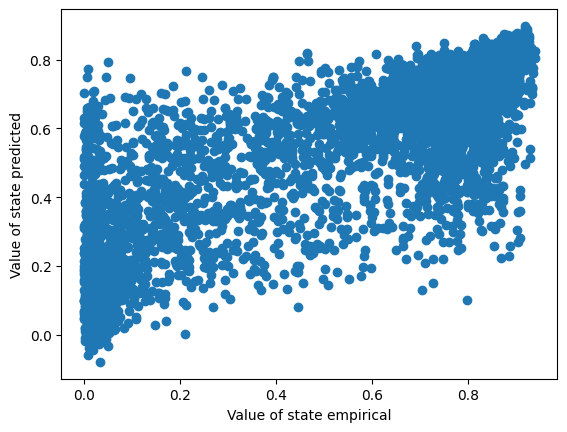

In [ ]:
# visualize the regression results
pvnet.eval()
V = []
V_pred = []
for s, v, p, g in test_data_pvnet:
    s = torch.tensor(s)[None, :, :].to(device).float()
    g = torch.tensor(g)[None, :].to(device).float()
    pi_pred, v_pred = pvnet(s, g)
    v_pred = np.squeeze((v_pred.detach().cpu().numpy()))
    V.append(v)
    V_pred.append(v_pred)

plt.scatter(V, V_pred)
plt.xlabel("Value of state empirical")
plt.ylabel("Value of state predicted")
plt.show()

Так как классификатор отсеивает плохие последовательности, то задача нейронной сети политики высоко оценивать хорошие состояния. Из рисунка видно, что большинство точек множества $[0.5, 1]$ эмпирических значений соответствуют точкам множества $[0.5, 1]$ предсказанных значений.

# **Результаты тестирования работы алгоритма манипулирования на основе обученных нейронных сетей**

Тестирование алгоритма манипулирования проводилось на основе указанного директория алгоритма в ide pycharm

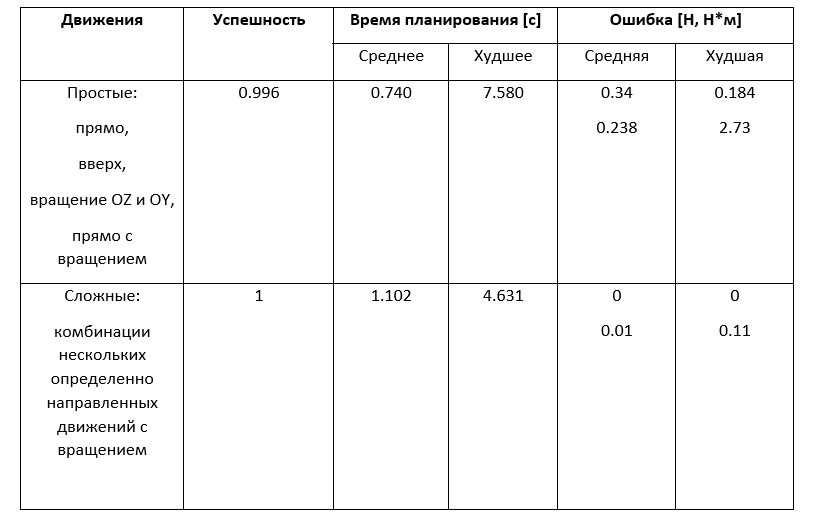

# **Вывод**

Результаты тестирования самого алгоритма манипулирования показывают, что обученные нейросети справляются со своей задачей как минимум на 99%